# Task 1
_Juan Lopez-Martin_

jl5522@columbia.edu

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('credit-g.csv')

### 1.1 Determine which features are continuous and which are categorical.

There are 7 continous variables and 14 categorical ones.

In [3]:
con_features = df.describe(include=np.number)
con_features.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object')

In [4]:
cat_features = df.describe(include=np.object)
cat_features.columns

Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

We can visualize it as a table:

In [5]:
con_features

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Plots are in general better if our intention is to get an idea about the distribution of some variables. However, the boxplot method that pandas implements is not particularly useful if the variables have a very different range:

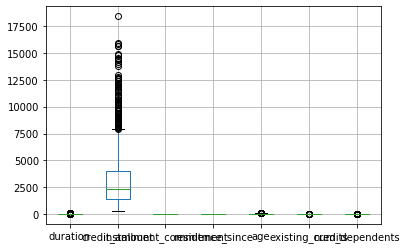

In [6]:
df[con_features.columns].boxplot()

We can create custom boxplots and histograms in a loop for a better understanding of the variables in this dataset:

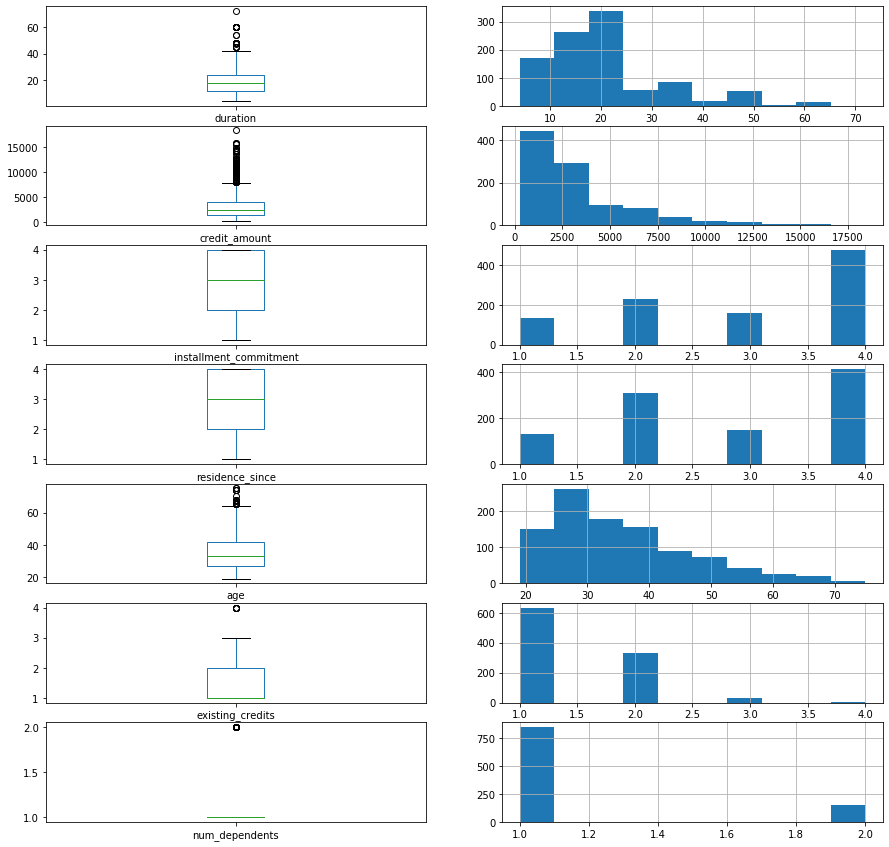

In [7]:
plt.rcParams["figure.figsize"] = (15,15)

fig, ax =  plt.subplots(7,2)

for i in range(0, 7):
    df[con_features.columns[i]].plot.box(ax=ax[i,0])
    df[con_features.columns[i]].hist(ax=ax[i,1])

plt.show()

We can also plot the target:

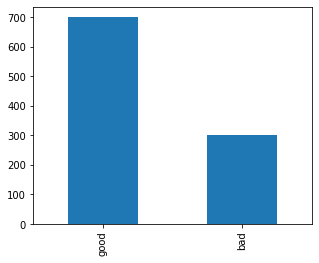

In [8]:
plt.rcParams["figure.figsize"] = (5,4)

df['class'].value_counts().plot(kind='bar')

### 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

Given the imbalance in the target, we will use the balanced_accuracy_score instead of the default accuracy_score, although we must say a different classification metric depending on our interests. As a reference, we must consider that a classifier that always predicted the most popular class (i.e. 'good') would obtain a balanced accuracy of 0.5.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer, balanced_accuracy_score

In [10]:
X = df.loc[:, df.columns != 'class']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
categorical = X_train.dtypes == object

preprocess = make_column_transformer(
    (preprocessing.StandardScaler(), ~categorical),
    (preprocessing.OneHotEncoder(), categorical))

In [12]:
from sklearn.linear_model import LogisticRegression
np.random.seed(1996)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train)
X_train1 = preprocess.fit_transform(X_train1)
X_val = preprocess.fit_transform(X_val)

clf = LogisticRegression(penalty='l2', C = 1, solver = 'lbfgs').fit(X_train1, y_train1)
balanced_accuracy_score(y_val, clf.predict(X_val))

0.6234375

### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [13]:
preprocess1 = make_column_transformer(
    (preprocessing.StandardScaler(), ~categorical),
    (preprocessing.OneHotEncoder(), categorical))

preprocess2 = make_column_transformer(
    (preprocessing.StandardScaler(), ~categorical))

Logistic regression, with and without scaling

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

logregmodel1 = make_pipeline(preprocess1, LogisticRegression(penalty='l2', C = 1, solver = 'lbfgs'))
logregmodel2 = make_pipeline(preprocess2, LogisticRegression(penalty='l2', C = 1, solver = 'lbfgs'))
scores1 = cross_val_score(logregmodel1, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
scores2 = cross_val_score(logregmodel2, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
print(np.mean(scores1))
print(np.mean(scores2))

0.6716066132390989
0.5498333495872463


Linear SVM, with and without scaling

In [15]:
from sklearn.svm import LinearSVC

linsvmmodel1 = make_pipeline(preprocess1, LinearSVC(penalty='l2', C = 1, max_iter = 2000))
linsvmmodel2 = make_pipeline(preprocess2, LinearSVC(penalty='l2', C = 1, max_iter = 2000))
scores1 = cross_val_score(linsvmmodel1, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
scores2 = cross_val_score(linsvmmodel2, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
print(np.mean(scores1))
print(np.mean(scores2))

0.6781102101344103
0.5435726291755825


K-nearest neighbors, with and without scaling

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knnmodel1 = make_pipeline(preprocess1, KNeighborsClassifier(n_neighbors = 5))
knnmodel2 = make_pipeline(preprocess2, KNeighborsClassifier(n_neighbors = 5))
scores1 = cross_val_score(knnmodel1, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
scores2 = cross_val_score(knnmodel2, X_train, y_train, cv=10, scoring = make_scorer(balanced_accuracy_score))
print(np.mean(scores1))
print(np.mean(scores2))

0.6284731265453168
0.5543410854936697


The results of the Logistic regression and linear SVM are almost the same (both using L2 regularization), something which is not surprising given these two approaches are very similar. Not doing the standardization step significantly reduces the accuracy of the three models, as the three require having the data in this form as they are based in models that take into account the scale of the variables. Note that we have used the default hyperparameters (C = 1 in the case of logistic regression and SVM, and Number of Neighbors = 5 in the KNN classifier).

### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.

#### K-Nearest Neighbors

In [17]:
from sklearn.model_selection import GridSearchCV

knnmodel = make_pipeline(preprocess, KNeighborsClassifier())

param_grid = {'kneighborsclassifier__n_neighbors':  np.arange(1, 40, 4)}
grid = GridSearchCV(knnmodel, cv = 10, 
                    param_grid = param_grid, return_train_score = True, iid = False, refit = True, 
                    scoring = make_scorer(balanced_accuracy_score))
grid.fit(X_train, y_train)

print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test, y_test)))

Mean cross-validation score of the best estimator: 0.629
Best parameters: {'kneighborsclassifier__n_neighbors': 13}
Test score: 0.602


We can plot the performance as a function of the parameters:

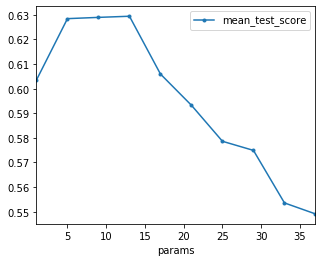

In [18]:
grid_results = pd.DataFrame(grid.cv_results_).loc[:, ['params', 'mean_test_score', 'std_test_score']]
grid_results['params'] = [list(dictionary.values())[0] for dictionary in grid_results.params]
grid_results = grid_results.set_index('params')
grid_results.loc[:, ['mean_test_score']].plot(style = '.-')

However, this plot is not taking into account the huge variation between the 10 cross-validation splits. It is also not displaying the train scores. Therefore, we build a function for a more complete graph:

In [19]:
def plot_grid(grid, log = True):
    grid_results = pd.DataFrame(grid.cv_results_).loc[:, ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
    grid_results['params'] = [list(dictionary.values())[0] for dictionary in grid_results.params]
    grid_results = grid_results.set_index('params')

    fig, ax = plt.subplots()
    ax.plot(grid_results.index, grid_results.mean_test_score, '.-', label='Test')
    ax.plot(grid_results.index, grid_results.mean_train_score, '.-', label='Train')
    if log == True:
        ax.set_xscale('log')
    ax.fill_between(grid_results.index, grid_results.mean_test_score - grid_results.std_test_score, grid_results.mean_test_score + grid_results.std_test_score, facecolor='blue', alpha=0.1)
    ax.fill_between(grid_results.index, grid_results.mean_train_score - grid_results.std_train_score, grid_results.mean_train_score + grid_results.std_train_score, facecolor='orange', alpha=0.2)
    ax.set_xlabel('Hyperparameter')
    ax.set_ylabel('Balanced Accuracy')
    plt.legend(loc='best')
    plt.show()

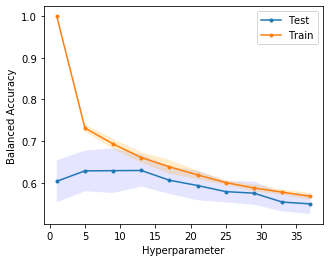

In [20]:
plot_grid(grid, log = False)

#### Linear Support Vector Machine

In [21]:
linsvmmodel = make_pipeline(preprocess, LinearSVC(penalty='l2', max_iter = 10000, dual=False))

param_grid = {'linearsvc__C':  np.logspace(-3, 3, 10)}
grid = GridSearchCV(linsvmmodel, cv = 10, 
                    param_grid = param_grid, return_train_score = True, iid = False, refit = True,
                    scoring = make_scorer(balanced_accuracy_score))
grid.fit(X_train, y_train)

print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test, y_test)))

Mean cross-validation score of the best estimator: 0.683
Best parameters: {'linearsvc__C': 10.0}
Test score: 0.673


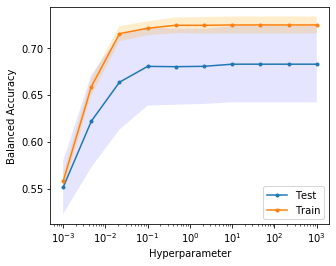

In [22]:
plot_grid(grid, log = True)

#### Logistic regression

In [23]:
logismodel = make_pipeline(preprocess, LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=10000))

param_grid = {'logisticregression__C':  np.logspace(-2, 2, 20)}
grid = GridSearchCV(logismodel, cv = 10, 
                    param_grid = param_grid, return_train_score = True, iid = False, refit = True, 
                    scoring = make_scorer(balanced_accuracy_score))
grid.fit(X_train, y_train)

print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test, y_test)))

Mean cross-validation score of the best estimator: 0.677
Best parameters: {'logisticregression__C': 61.584821106602604}
Test score: 0.680


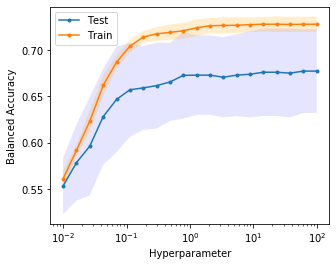

In [24]:
plot_grid(grid, log = True)

#### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

Shuffling introduces a random element that makes the result vary from the ones obtained in the previous section, and that also change when the random seed is modified.  A new train-test split in the data introduces another randomization factor, which makes the result different even if maintaining the random seed. 

In [25]:
from sklearn.model_selection import KFold

In [26]:
logismodel = make_pipeline(preprocess, LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=5000))

param_grid = {'logisticregression__C':  np.logspace(-2, 2, 10)}
grid = GridSearchCV(logismodel, cv = KFold(n_splits = 10, shuffle = True), 
                    param_grid = param_grid, return_train_score = True, iid = False, refit = True, 
                    scoring = make_scorer(balanced_accuracy_score))

Mean cross-validation score of the best estimator: 0.670
Best parameters: {'logisticregression__C': 1.6681005372000592}
Test score: 0.676


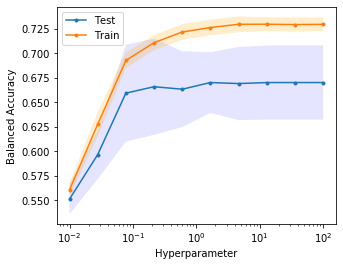

In [27]:
np.random.seed(2020)
grid.fit(X_train, y_train)
print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test, y_test)))

plot_grid(grid, log = True)

Mean cross-validation score of the best estimator: 0.682
Best parameters: {'logisticregression__C': 12.915496650148826}
Test score: 0.680


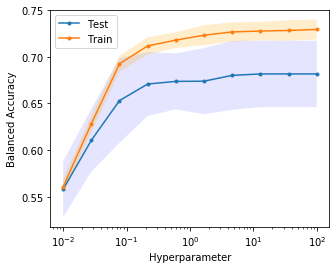

In [28]:
np.random.seed(2019)
grid.fit(X_train, y_train)
print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test, y_test)))

plot_grid(grid, log = True)

Mean cross-validation score of the best estimator: 0.668
Best parameters: {'logisticregression__C': 1.6681005372000592}
Test score: 0.675


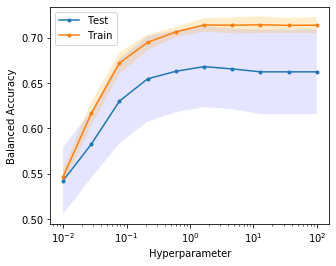

In [29]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y)
grid.fit(X_train_new, y_train_new)
print("Mean cross-validation score of the best estimator: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Test score: {:.3f}".format(grid.score(X_test_new, y_test_new)))

plot_grid(grid, log = True)

#### 1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [30]:
best_logistic = grid.best_estimator_[1] # best_estimator_ is a pipeline which contains the transformation and linear regression

In [31]:
# Get names parameters
names1 = list(X_train.select_dtypes(exclude = 'object').columns)
names2 = list(preprocessing.OneHotEncoder().fit(X_train.select_dtypes('object')).get_feature_names())
names = names1 + names2

coefs = pd.Series(best_logistic.coef_[0], index = names)
greater_cofs_abs = coefs.abs().sort_values(ascending = False)[0:19]
greater_cofs = coefs.loc[greater_cofs_abs.index]

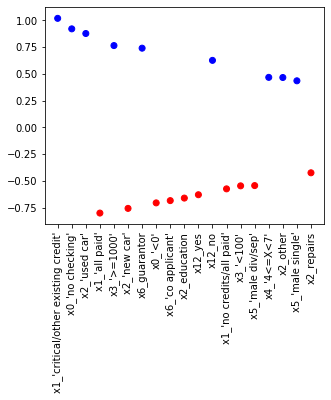

In [32]:
plt.scatter(greater_cofs.index, greater_cofs, c = np.sign(greater_cofs), cmap="bwr_r")
plt.xticks(rotation=90)
plt.show()